# Note

This notebook is provided as an example, it needs to be adapted to work with non-custom models (`"clip-vit-l-336px-aligned"` is not available on timm)

# Prepare output heads

In [1]:
import os
import torch
from notebook_utils import prepare_backbone, prepare_output_head

print(torch.cuda.get_device_name(0))  # Results may vary slightly across GPUs, we train on NVIDIA H100 80GB HBM3.

NVIDIA H100 80GB HBM3


In [2]:
backbone_name = "clip-vit-l-336px"
backbone_aligned_name = "clip-vit-l-336px-aligned"

In [3]:
# Train script must be run from parent directory.
%cd -q ..

In [4]:
# Get output head for original model.
if os.path.exists(f"saved_models/{backbone_name}-coco-union-transformer.pth"):
    # Get backbone.
    print("Trained output head exists, loading instead of training")
    orig_backbone, orig_data_config = prepare_backbone(backbone_name, "transformer", "union", 0)

    # Load output head.
    orig_output_head = prepare_output_head("transformer", orig_data_config, "union", None, 2, 183)
    checkpoint = torch.load(f"saved_models/{backbone_name}-coco-union-transformer.pth")
    orig_output_head.load_state_dict(checkpoint)

    # Move to GPU.
    orig_output_head = orig_output_head.cuda()
    orig_backbone = orig_backbone.cuda()

else:
    # Run train script.
    print("Saved output head does not exist, training")
    %run -t scripts/train.py --backbone {backbone_name} --no-save --log-every 1000

    orig_output_head = output_head
    orig_backbone = backbone
    orig_data_config = backbone_config

    # Save output head.
    os.makedirs("saved_models", exist_ok=True)
    torch.save(orig_output_head.state_dict(), f"saved_models/{backbone_name}-coco-union-transformer.pth")
    print("Saved trained output head")

Trained output head exists, loading instead of training


/nlp/scr/icovert/miniconda3/envs/images/lib/python3.10/site-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cached_file, ma

In [5]:
# Get output head for aligned model.
if os.path.exists(f"saved_models/{backbone_aligned_name}-coco-union-transformer.pth"):
    # Get backbone.
    print("Trained output head exists, loading instead of training")
    aligned_backbone, aligned_data_config = prepare_backbone(backbone_aligned_name, "transformer", "union", 0)

    # Load output head.
    aligned_output_head = prepare_output_head("transformer", aligned_data_config, "union", None, 2, 183)
    checkpoint = torch.load(f"saved_models/{backbone_aligned_name}-coco-union-transformer.pth")
    aligned_output_head.load_state_dict(checkpoint)

    # Move to GPU.
    aligned_output_head = aligned_output_head.cuda()
    aligned_backbone = aligned_backbone.cuda()

else:
    # Run train script.
    print("Saved output head does not exist, training")
    %run -t scripts/train.py --backbone {backbone_aligned_name} --no-save --log-every 1000

    aligned_output_head = output_head
    aligned_backbone = backbone
    aligned_data_config = backbone_config

    # Save output head.
    os.makedirs("saved_models", exist_ok=True)
    torch.save(aligned_output_head.state_dict(), f"saved_models/{backbone_aligned_name}-coco-union-transformer.pth")
    print("Saved trained output head")

Trained output head exists, loading instead of training


/juice5/scr5/icovert/image-sandbox/masked-distillation/masked_distillation/train_utils.py:254: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoi

# Prepare validation data

In [6]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch.nn as nn
from torch.utils.data import DataLoader

from patchseg.dataset import CocoPatchDataset, coco_index_to_class

In [7]:
# Get the mean and std of the images.
assert orig_data_config["image_mean"] == aligned_data_config["image_mean"]
assert orig_data_config["image_std"] == aligned_data_config["image_std"]
image_mean, image_std = orig_data_config["image_mean"], orig_data_config["image_std"]

# Get the image width.
assert orig_data_config["image_width"] == aligned_data_config["image_width"]
image_width = orig_data_config["image_width"]

# Get the patch size.
assert orig_data_config["patch_size"] == aligned_data_config["patch_size"]
assert orig_data_config["num_patches"] == aligned_data_config["num_patches"]
assert orig_data_config["num_patches"] ** 0.5 * orig_data_config["patch_size"] == image_width
patch_size = orig_data_config["patch_size"]

In [8]:
# Prepare dataset.
val_dataset = CocoPatchDataset(
    image_width=image_width,
    patch_size=patch_size,
    split="val",
    image_mean=image_mean,
    image_std=image_std,
    label_reduction="union",
)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=0, shuffle=True)

# Plot predictions

In [9]:
def get_top_n_class(annotations: torch.Tensor, n: int) -> tuple[list[list[int]], list[list[str]]]:
    """Get top n class indices and names from annotations."""
    # `Things` classes are from 1 to 91.
    include_idxs = torch.arange(1, 92)

    # Get indices of top n frequent classes.
    class_idxs = annotations.sum(dim=(1, 2))
    class_idxs = class_idxs[:, include_idxs]
    class_counts = (class_idxs > 0).sum(dim=1).clamp(max=n)
    class_idxs = class_idxs.argsort(descending=True, dim=-1)[:, :n]
    class_idxs = include_idxs[class_idxs].tolist()

    # Get class names.
    class_names = []
    for i, class_count in enumerate(class_counts):
        image_classes = [coco_index_to_class[str(class_idxs[i][j])] for j in range(class_count)]
        class_idxs[i] = class_idxs[i][:class_count]
        class_names.append(image_classes)

    return class_idxs, class_names


def get_model_prediction(images: torch.Tensor, backbone: nn.Module, output_head: nn.Module) -> torch.Tensor:
    """Get model prediction over images."""
    with torch.no_grad():
        features = backbone(images.cuda())
        logits = output_head(features)
    probs = torch.sigmoid(logits)
    return probs.cpu()


def upscale_tensor(patch_values: torch.Tensor, scale_factor: int) -> torch.Tensor:
    """Upscales patch values by a given scale factor."""
    if patch_values.dim() == 3:
        batch_size, num_patches, num_classes = patch_values.shape
        patch_values = patch_values.view(batch_size, int(num_patches**0.5), int(num_patches**0.5), num_classes)

    patch_values = patch_values.repeat_interleave(scale_factor, dim=1).repeat_interleave(scale_factor, dim=2)
    return patch_values

In [10]:
# Prepare batch of images and annotations.
images, annotations = next(iter(val_loader))

In [11]:
# Get top n classes.
n = 5
class_idxs, class_names = get_top_n_class(annotations, n)

# Get model predictions.
orig_probs = get_model_prediction(images, orig_backbone, orig_output_head)
aligned_probs = get_model_prediction(images, aligned_backbone, aligned_output_head)

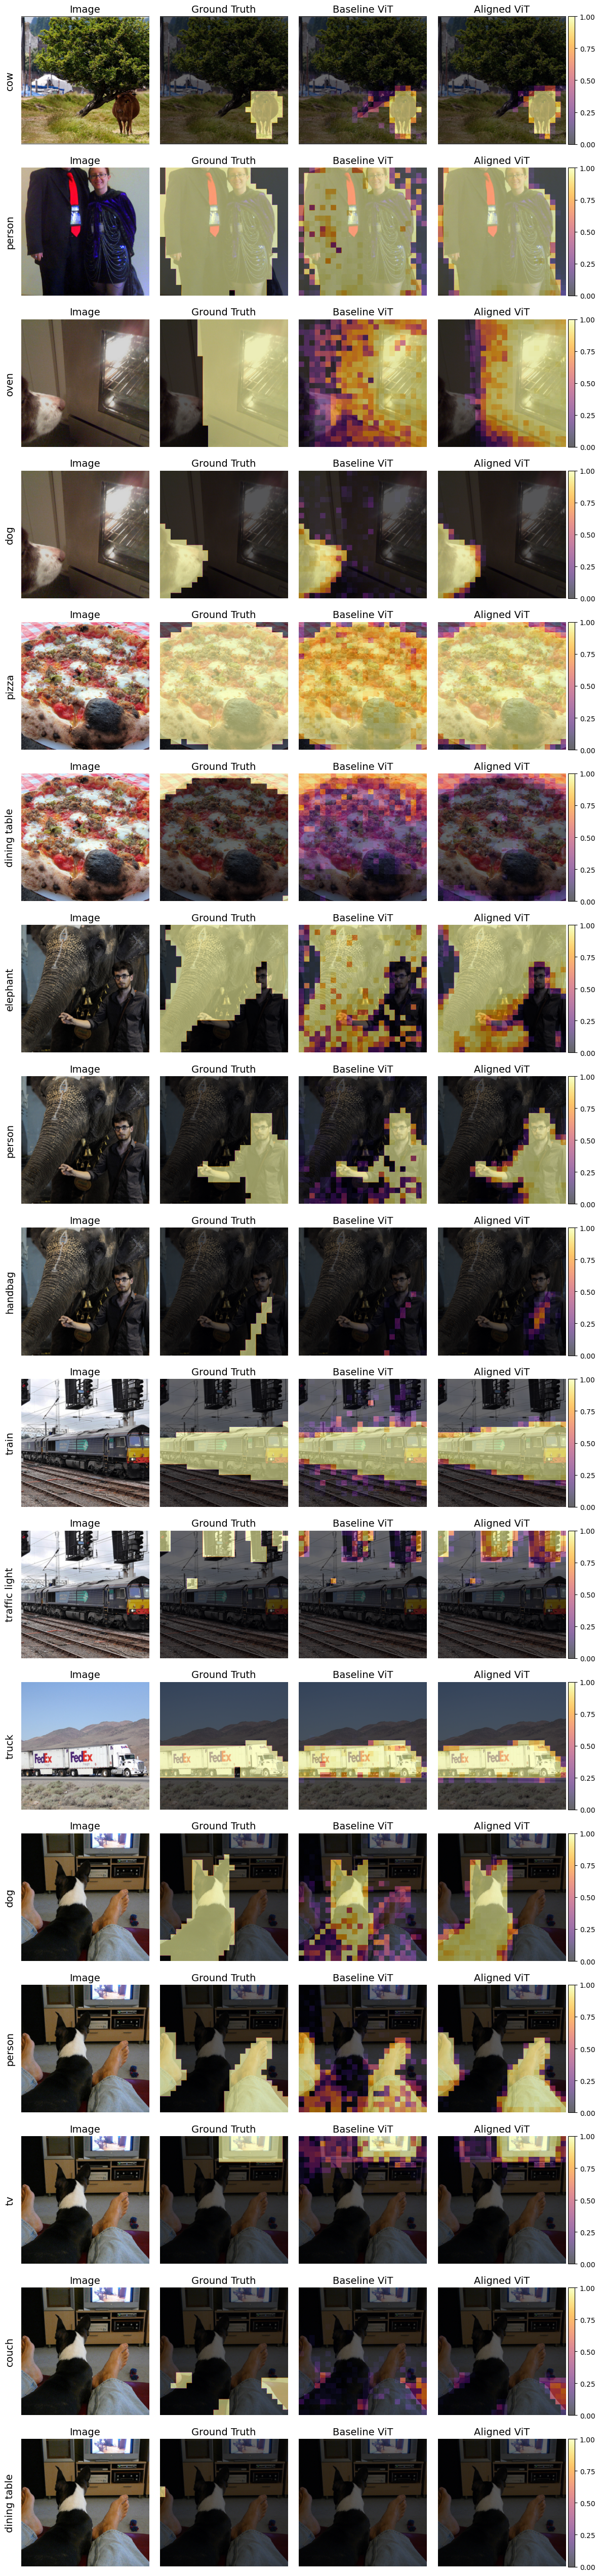

In [12]:
# Upscale predictions and annotations.
upscaled_annotations = upscale_tensor(annotations, scale_factor=patch_size)
upscaled_orig_probs = upscale_tensor(orig_probs, scale_factor=patch_size)
upscaled_aligned_probs = upscale_tensor(aligned_probs, scale_factor=patch_size)

# Calculate figure size dynamically.
total_rows = sum([len(c) for c in class_idxs])

width_per_column = 3
height_per_row = 3

fig_width = width_per_column * 4
fig_height = height_per_row * total_rows

fig, axarr = plt.subplots(total_rows, 4, figsize=(fig_width, fig_height), gridspec_kw={"width_ratios": [1, 1, 1, 1.07]})

cmap = colormaps.get_cmap("inferno")

r = 0
for i, (image, idxs, names) in enumerate(zip(images, class_idxs, class_names)):
    # Image only.
    image_std_tensor = torch.tensor(image_std).view(-1, 1, 1)
    image_mean_tensor = torch.tensor(image_mean).view(-1, 1, 1)

    display_image = (image_std_tensor * image + image_mean_tensor).permute(1, 2, 0)

    assert len(idxs) == len(names)
    for j in range(len(idxs)):
        idx = idxs[j]
        name = names[j]

        # Show image for first row of classes only.
        axarr[r, 0].imshow(display_image)
        axarr[r, 0].axis("off")

        # Ground truth.
        axarr[r, 1].imshow(display_image)
        display_annotation = upscaled_annotations[i, ..., idx]
        axarr[r, 1].imshow(display_annotation, alpha=0.6, cmap=cmap, vmin=0, vmax=1)
        axarr[r, 1].axis("off")

        # Original model predictions.
        axarr[r, 2].imshow(display_image)
        display_orig_probs = upscaled_orig_probs[i, ..., idx]
        axarr[r, 2].imshow(display_orig_probs, alpha=0.6, cmap=cmap, vmin=0, vmax=1)
        axarr[r, 2].axis("off")

        # Aligned predictions.
        axarr[r, 3].imshow(display_image)
        display_aligned_probs = upscaled_aligned_probs[i, ..., idx]
        im_aligned = axarr[r, 3].imshow(display_aligned_probs, alpha=0.6, cmap=cmap, vmin=0, vmax=1)
        axarr[r, 3].axis("off")

        # Add colorbar on last column.
        divider = make_axes_locatable(axarr[r, 3])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar_aligned = fig.colorbar(im_aligned, cax=cax)
        cbar_aligned.set_ticks([0, 0.25, 0.5, 0.75, 1])

        # Add class name as text to the left of the first image.
        axarr[r, 0].text(
            -0.05,
            0.5,
            f"{name}",
            horizontalalignment="right",
            verticalalignment="center",
            transform=axarr[r, 0].transAxes,
            rotation="vertical",
            fontsize=14,
        )

        # Set subplot labels.
        axarr[r, 0].set_title("Image", fontsize=14)
        axarr[r, 1].set_title("Ground Truth", fontsize=14)
        axarr[r, 2].set_title("Baseline ViT", fontsize=14)
        axarr[r, 3].set_title("Aligned ViT", fontsize=14)

        r += 1

plt.tight_layout()
plt.savefig("notebooks/figures/patchseg_qualitative.png", dpi=300)
plt.show()